In [41]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field   
from langchain_groq import ChatGroq

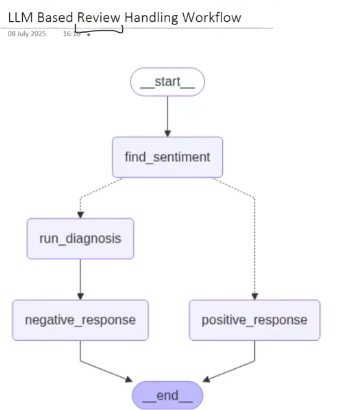

In [42]:
load_dotenv()

True

In [43]:
model = ChatGroq(model="llama-3.1-8b-instant")

In [44]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description='Sentiment of the review')


In [45]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [46]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [47]:
prompt = 'What is the sentiment of the following review - The software too good'
structured_model.invoke(prompt).sentiment

'positive'

In [48]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [49]:
def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [50]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

In [53]:
intial_state={
    'review': "I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial. Great job to the design team!"
}
workflow.invoke(intial_state)

{'review': "I've been using this app for about a month now, and I must say, the user interface is incredibly clean and intuitive. Everything is exactly where you'd expect it to be. It's rare to find something that just works without needing a tutorial. Great job to the design team!",
 'sentiment': 'positive',
 'response': '"Dear [Reviewer\'s Name],\n\nWe\'re thrilled to hear that you\'ve had a seamless experience using our app! Our team has worked hard to create an interface that is both clean and user-friendly, and it\'s wonderful to know that our efforts have paid off.\n\nWe\'re grateful for your kind words and appreciate the time you took to share your feedback. Your input helps us to continue improving our product, and we\'re glad that you found it easy to navigate without needing a tutorial.\n\nIf you\'d like to share more of your thoughts and suggestions, we\'d love to hear them on our website. Your feedback can help us shape the future of our app and make it even better for you 

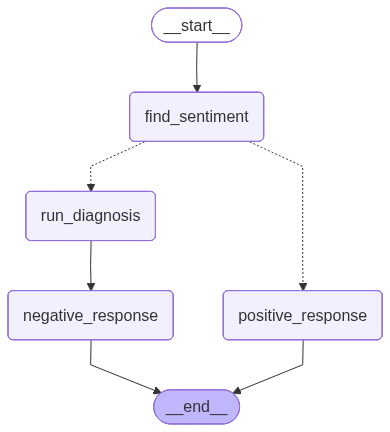

In [52]:
workflow